In [36]:
import pandas as pd
import numpy as np
import requests
from pandas.tseries.offsets import BDay
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, LeakyReLU
from keras.optimizers import Adam
from tensorflow.keras.initializers import Orthogonal
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from scipy.stats import linregress
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Define the API key and base URL
api_key = 'beBybSi8daPgsTp5yx5cHtHpYcrjp5Jq'

# Define the currency pairs and years
currency_pairs = ["USDEUR", "USDCAD", "USDAUD", "USDCHF", "USDGBP"]
years = range(2022, 2024)
num_of_outliers_per_year = 15

In [3]:
def calculate_daily_return(df):
    # Use pct_change() to calculate the percentage change in 'c' (close prices)
    df['daily_return'] = df['c'].pct_change()
    df['abs_daily_return'] = df['daily_return'].abs()
    return df

def get_top_outliers(df, n=num_of_outliers_per_year):
    return df.nlargest(n, 'abs_daily_return')

# Initialize DataFrames
full_data = pd.DataFrame()
outliers_data = pd.DataFrame()

# Loop over each currency pair and year
for pair in currency_pairs:
    for year in years:
        # Format the API endpoint
        start_date = f'{year}-01-01'
        end_date = f'{year}-12-31'
        url = f"https://api.polygon.io/v2/aggs/ticker/C:{pair}/range/1/day/{start_date}/{end_date}?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"

        # Make the API request
        response = requests.get(url)
        data = response.json()

        # Check if the request was successful
        if response.status_code == 200 and 'results' in data:
            # Load data into a DataFrame
            df = pd.DataFrame(data['results'])
            # Convert timestamps
            df['date'] = pd.to_datetime(df['t'], unit='ms')
            df.drop(columns=['t'], inplace=True)

            df = df[df['date'].dt.weekday < 5]
            # Calculating returns
            df = calculate_daily_return(df)

            # Append the data to the full_data DataFrame for the current currency pair
            df['year'] = year
            df['day'] = df['date'].dt.day_name()
            df['pair'] = pair  # Added pair name to track different currencies

            # Find the top 15 outliers based on absolute values of the daily return value
            top_outliers = get_top_outliers(df, n=num_of_outliers_per_year)
            outlier_dates = top_outliers['date']

            # Create a new column 'is_outlier' in the full_data DataFrame
            df['is_outlier'] = df['date'].isin(outlier_dates).astype(int)
            full_data = pd.concat([full_data, df], ignore_index=True)

            # Append outliers to the outliers_data DataFrame for the current currency pair
            top_outliers['year'] = year
            outliers_data = pd.concat([outliers_data, top_outliers], ignore_index=True)

sorted_full_data = full_data.sort_values(by="date")
sorted_outliers_data = outliers_data.sort_values(by="date")

In [4]:
sorted_full_data

,v,vw,o,c,h,l,n,date,daily_return,abs_daily_return,year,day,pair,is_outlier
0,57901,0.8828,0.87925,0.884780,0.886510,0.879020,57901,2022-01-03,NaN,NaN,2022,Monday,USDEUR,0
1040,107378,1.3838,1.37586,1.389275,1.391905,1.373600,107378,2022-01-03,NaN,NaN,2022,Monday,USDAUD,0
1560,112859,0.9156,0.91203,0.918330,0.919990,0.911300,112859,2022-01-03,NaN,NaN,2022,Monday,USDCHF,0
2080,49568,0.7413,0.73951,0.741660,0.744510,0.739000,49568,2022-01-03,NaN,NaN,2022,Monday,USDGBP,0
520,101270,1.2714,1.26584,1.275000,1.277900,1.264200,101270,2022-01-03,NaN,NaN,2022,Monday,USDCAD,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2079,214081,0.8403,0.84346,0.840710,0.843560,0.835400,214081,2023-12-29,-0.003154,0.003154,2023,Friday,USDCHF,0
1039,112236,1.3231,1.32301,1.309580,1.326520,1.300480,112236,2023-12-29,-0.009994,0.009994,2023,Friday,USDCAD,1
519,78410,0.9040,0.90346,0.905800,0.906250,0.902000,78410,2023-12-29,0.002568,0.002568,2023,Friday,USDEUR,0
1559,146533,1.4662,1.46471,1.455202,1.474622,1.445985,146533,2023-12-29,-0.006243,0.006243,2023,Friday,USDAUD,0


In [5]:
# Convert dates in dataset to datetime objects
sorted_outliers_data['date'] = pd.to_datetime(sorted_outliers_data['date'])

date_ranges = pd.DataFrame({
    "start_date": sorted_outliers_data['date'] - BDay(14), # To predict X days, keep this as X-1 (as 1 day of outlier will be considered in LSTM input)
    "end_date": sorted_outliers_data['date'] + BDay(15),
    "outlier_date": sorted_outliers_data['date'],
    "outlier_price": sorted_outliers_data['c'],
    "daily_return": sorted_outliers_data['daily_return'],
    "pair": sorted_outliers_data['pair']
})

date_ranges.reset_index(drop=True, inplace=True)

date_ranges

,start_date,end_date,outlier_date,outlier_price,daily_return,pair
0,2022-02-17,2022-03-30,2022-03-09,0.903020,-0.015868,USDEUR
1,2022-02-22,2022-04-04,2022-03-14,1.388696,0.020608,USDAUD
2,2022-04-05,2022-05-16,2022-04-25,1.393100,0.026561,USDAUD
3,2022-04-14,2022-05-25,2022-05-04,1.379025,-0.020768,USDAUD
4,2022-04-15,2022-05-26,2022-05-05,0.808850,0.020541,USDGBP
...,...,...,...,...,...,...
145,2023-10-25,2023-12-05,2023-11-14,0.889100,-0.013427,USDCHF
146,2023-11-23,2024-01-03,2023-12-13,1.500218,-0.015152,USDAUD
147,2023-11-24,2024-01-04,2023-12-14,0.782990,-0.011688,USDGBP
148,2023-12-07,2024-01-17,2023-12-27,0.842500,-0.013142,USDCHF


In [6]:
def fetch_daily_data(pair, start_date, end_date, api_key):
    formatted_start_date = start_date.strftime('%Y-%m-%d')
    formatted_end_date = end_date.strftime('%Y-%m-%d')

    url = f"https://api.polygon.io/v2/aggs/ticker/C:{pair}/range/1/day/{formatted_start_date}/{formatted_end_date}?adjusted=true&sort=asc&apiKey={api_key}"
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Failed to fetch data: {response.status_code} - {response.text}")
        return None

    response_data = response.json()

    if 'results' not in response_data:
        print(f"No 'results' in response: {response_data}")
        return None

    df = pd.DataFrame(response_data['results'])
    df['date'] = pd.to_datetime(df['t'], unit='ms')
    df.drop(columns=['t'], inplace=True)

    daily_data = calculate_daily_return(df)
    daily_data.set_index('date', inplace=True)

    return daily_data

def fetch_and_process_daily_data(pair, start_date, end_date, api_key):
    daily_data = fetch_daily_data(pair, start_date, end_date, api_key)

    if daily_data is None:
        print("No data fetched")
        return None

    daily_data.reset_index(inplace=True)
    return daily_data

In [7]:
# Create an empty list to store the model performance metrics for each outlier
trade_results_list = []

# Define the stop-loss percentage
stop_loss_percentage = 0.01  # 1% stop loss

# Loop through each outlier in date_ranges
for idx, row in date_ranges.iterrows():
	start_date_co = pd.Timestamp(row['start_date'])
	end_date_co = pd.Timestamp(row['end_date']) + pd.Timedelta(days=1)
	outlier_date_co = pd.Timestamp(row['outlier_date'])

	# Fetch the currency pair for the current outlier
	pair = row['pair']

	# Fetch and process daily data for the current range
	daily_data = fetch_and_process_daily_data(pair, start_date_co, end_date_co, api_key)

	if daily_data is None:
		print(f"No data fetched for outlier_id: {idx + 1}")
		continue  # Skip to the next iteration if no data

	# Filter out weekends
	daily_data = daily_data[~daily_data['date'].dt.weekday.isin([5, 6])]

	# Sort data by date
	daily_data = daily_data.sort_values(by='date', ascending=True)

	# Fill missing values
	daily_data.fillna(method='bfill', inplace=True)
	daily_data.fillna(method='ffill', inplace=True)

	# Split the dataset into train and test sets
	train_set = daily_data.iloc[:15].reset_index(drop=True)
	test_set = daily_data.iloc[15:].reset_index(drop=True)

	# Normalize the data using only the training data
	scaler = MinMaxScaler()
	train_scaled = scaler.fit_transform(train_set[["c"]])

	# Prepare data for LSTM model
	sequence_length = 12
	train_generator = TimeseriesGenerator(train_scaled, train_scaled, length=sequence_length, batch_size=1)
	validation_generator = TimeseriesGenerator(train_scaled, train_scaled, length=sequence_length, batch_size=1)

	# Within the Sequential model definition:
	model = Sequential([
		LSTM(64, return_sequences=True, input_shape=(sequence_length, 1), kernel_initializer=Orthogonal()),
		LeakyReLU(alpha=0.01),  # Specify LeakyReLU with a small alpha
		Dropout(0.2),
		LSTM(32),  # Last LSTM layer may not return sequences by default
		LeakyReLU(alpha=0.01),  # Specify LeakyReLU with a small alpha
		Dropout(0.2),
		Dense(1)
	])
	model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

	# Early stopping to avoid overfitting
	early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

	# Fit the model with validation data
	history = model.fit(train_generator, epochs=100, verbose=0, validation_data=validation_generator, callbacks=[early_stopping])

	# Prepare the last sequence for forecasting
	last_sequence = train_scaled[-sequence_length:]

	# Forecast the next steps
	forecast_steps = len(test_set)
	predictions_scaled = []
	for _ in range(forecast_steps):
		last_sequence_reshaped = last_sequence.reshape((1, sequence_length, 1))
		next_step_pred = model.predict(last_sequence_reshaped, verbose=0)
		predictions_scaled.append(next_step_pred.ravel()[0])
		last_sequence = np.roll(last_sequence, -1)
		last_sequence[-1] = next_step_pred

	# Inverse transform predictions
	predictions_inv = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))

	# Actual values for comparison
	actuals = test_set["c"].values[:forecast_steps]

	# Calculate MAPE (Mean Absolute Percentage Error)
	mse = mean_squared_error(actuals, predictions_inv)
	rmse = np.sqrt(mse)
	mape = mean_absolute_percentage_error(actuals, predictions_inv)
	accuracy = np.round(100 - (mape * 100), 2)

	# Append these lines right after fetching the 'actuals' values
	actual_days = np.arange(1, len(actuals) + 1)
	actual_slope, _, _, _, _ = linregress(actual_days, actuals)

	# Determine the actual market trend based on the slope and outlier type
	if row['daily_return'] > 0:  # Positive outlier
		actual_market_trend = "Momentum Continuation" if actual_slope > 0 else "Mean Reversion"
	else:  # Negative outlier
		actual_market_trend = "Momentum Continuation" if actual_slope < 0 else "Mean Reversion"

	# Determine if the outlier is positive or negative
	outlier_return = row['daily_return']
	is_positive_outlier = outlier_return > 0  # Check if the outlier is positive based on its daily return value
	outlier_type = "Positive" if is_positive_outlier else "Negative"  # Define outlier type

	# Create an array for time (days 1 to 12)
	days = np.arange(1, len(predictions_inv) + 1)
	# Perform linear regression to identify the trend
	slope, intercept, r_value, p_value, std_err = linregress(days, predictions_inv.ravel())

	market_trend = ""
	trade_initiated = False
	entry_price = None
	exit_price = None
	entry_date = None
	exit_date = None
	profit = 0
	days_held = 0
	position_type = None

	if outlier_type == "Positive":
		if slope > 0:
			market_trend = "Momentum Continuation"
			# Go long: find buy low, sell high
			exit_idx = np.argmax(predictions_inv)
			entry_idx = np.argmin(predictions_inv[:exit_idx + 1])

			exit_price = predictions_inv[exit_idx][0]
			entry_price = predictions_inv[entry_idx][0]
			entry_date = test_set.iloc[entry_idx]['date']
			exit_date = test_set.iloc[exit_idx]['date']
			
			# Calculate stop-loss price for a long position
			stop_loss_price = entry_price * (1 - stop_loss_percentage)

			# Check if stop-loss is triggered during the period held
			for i in range(entry_idx, exit_idx + 1):
				current_price = predictions_inv[i][0]
				if current_price <= stop_loss_price:
					exit_price = current_price  # Update exit price to stop-loss price
					exit_date = test_set.iloc[i]['date']
					break  # Exit the loop and trade

			# Calculate profit
			profit = (exit_price - entry_price) * 100 / entry_price
			days_held = (exit_idx - entry_idx)
			position_type = "Long"
			trade_initiated = True
		else:
			market_trend = "Mean Reversion"
			# Go short: find sell high, buy low
			entry_idx = np.argmax(predictions_inv)
			exit_idx = np.argmin(predictions_inv[entry_idx:]) + entry_idx

			entry_price = predictions_inv[entry_idx][0]
			exit_price = predictions_inv[exit_idx][0]
			entry_date = test_set.iloc[entry_idx]['date']
			exit_date = test_set.iloc[exit_idx]['date']
			
			# Calculate stop-loss price for a short position
			stop_loss_price = entry_price * (1 + stop_loss_percentage)

			# Check if stop-loss is triggered during the period held
			for i in range(entry_idx, exit_idx + 1):
				current_price = predictions_inv[i][0]
				if current_price >= stop_loss_price:
					entry_price = current_price  # Update entry price to stop-loss price
					entry_date = test_set.iloc[i]['date']
					break  # Exit the loop and trade

			# Calculate profit
			profit = (entry_price - exit_price) * 100 / entry_price
			days_held = (exit_idx - entry_idx)
			position_type = "Short"
			trade_initiated = True

	else:  # Negative outlier
		if slope < 0:
			market_trend = "Momentum Continuation"
			# Go short: find sell high, buy low
			entry_idx = np.argmax(predictions_inv)
			exit_idx = np.argmin(predictions_inv[entry_idx:]) + entry_idx

			entry_price = predictions_inv[entry_idx][0]
			exit_price = predictions_inv[exit_idx][0]
			entry_date = test_set.iloc[entry_idx]['date']
			exit_date = test_set.iloc[exit_idx]['date']
			
			# Calculate stop-loss price for a short position
			stop_loss_price = entry_price * (1 + stop_loss_percentage)

			# Check if stop-loss is triggered during the period held
			for i in range(entry_idx, exit_idx + 1):
				current_price = predictions_inv[i][0]
				if current_price >= stop_loss_price:
					entry_price = current_price  # Update entry price to stop-loss price
					entry_date = test_set.iloc[i]['date']
					break  # Exit the loop and trade

			# Calculate profit
			profit = (entry_price - exit_price) * 100 / entry_price
			days_held = (exit_idx - entry_idx)
			position_type = "Short"
			trade_initiated = True
		else:
			market_trend = "Mean Reversion"
			# Go long: find buy low, sell high
			exit_idx = np.argmax(predictions_inv)
			entry_idx = np.argmin(predictions_inv[:exit_idx + 1])

			exit_price = predictions_inv[exit_idx][0]
			entry_price = predictions_inv[entry_idx][0]
			entry_date = test_set.iloc[entry_idx]['date']
			exit_date = test_set.iloc[exit_idx]['date']
			
			# Calculate stop-loss price for a long position
			stop_loss_price = entry_price * (1 - stop_loss_percentage)

			# Check if stop-loss is triggered during the period held
			for i in range(entry_idx, exit_idx + 1):
				current_price = predictions_inv[i][0]
				if current_price <= stop_loss_price:
					exit_price = current_price  # Update exit price to stop-loss price
					exit_date = test_set.iloc[i]['date']
					break  # Exit the loop and trade

			# Calculate profit
			profit = (exit_price - entry_price) * 100 / entry_price
			days_held = (exit_idx - entry_idx)
			position_type = "Long"
			trade_initiated = True

	# Append trade results for every outlier, even if no trade was initiated
	trade_results_list.append({
	'Outlier Date': outlier_date_co,
	'Outlier Price': row['outlier_price'],
	'Outlier Type': outlier_type,
	'Actual Market Trend': actual_market_trend,
	'Predicted Market Trend': market_trend,
	'Position Type': position_type,
	'Entry Date': entry_date,
	'Entry Price': entry_price,
	'Exit Date': exit_date,
	'Exit Price': exit_price,
	'Trading Days': days_held,
	'Profit': profit,
	'model_RMSE': rmse,
	'model_accuracy': accuracy,
	'Pair': row['pair']
})

# Convert the list of dictionaries to a DataFrame
trade_results_df = pd.DataFrame(trade_results_list)

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_13641/717679580.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_data.fillna(method='bfill', inplace=True)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_13641/717679580.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_data.fillna(method='ffill', inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning

In [9]:
sorted_trade_results_df = trade_results_df.sort_values(by=['Pair', 'Outlier Date'], ascending=[True, True])
sorted_trade_results_df.reset_index(drop=True, inplace=True)

sorted_trade_results_df

,Outlier Date,Outlier Price,Outlier Type,Actual Market Trend,Predicted Market Trend,Position Type,Entry Date,Entry Price,Exit Date,Exit Price,Trading Days,Profit,model_RMSE,model_accuracy,Pair
0,2022-03-14,1.388696,Positive,Mean Reversion,Mean Reversion,Short,2022-03-16,1.369260,2022-03-30,1.369165,10,0.006965,0.035005,97.57,USDAUD
1,2022-04-25,1.393100,Positive,Momentum Continuation,Momentum Continuation,Long,2022-04-26,1.372649,2022-05-11,1.375228,11,0.187883,0.049759,96.78,USDAUD
2,2022-05-04,1.379025,Negative,Momentum Continuation,Mean Reversion,Long,2022-05-06,1.401013,2022-05-16,1.401164,6,0.010764,0.028416,98.37,USDAUD
3,2022-06-13,1.440507,Positive,Momentum Continuation,Mean Reversion,Short,2022-06-14,1.412330,2022-06-29,1.411839,11,0.034775,0.035653,97.74,USDAUD
4,2022-07-11,1.483500,Positive,Mean Reversion,Momentum Continuation,Long,2022-07-12,1.462145,2022-07-27,1.463313,11,0.079875,0.025321,98.45,USDAUD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2023-08-24,0.794100,Positive,Momentum Continuation,Momentum Continuation,Long,2023-08-25,0.793082,2023-08-28,0.793265,1,0.023133,0.007514,99.22,USDGBP
146,2023-10-12,0.820800,Positive,Mean Reversion,Momentum Continuation,Long,2023-10-25,0.812936,2023-11-01,0.839220,5,3.233209,0.011086,98.82,USDGBP
147,2023-11-03,0.808016,Negative,Momentum Continuation,Momentum Continuation,Short,2023-11-06,0.816272,2023-11-21,0.815314,11,0.117373,0.012295,98.71,USDGBP
148,2023-11-14,0.800350,Negative,Momentum Continuation,Momentum Continuation,Short,2023-11-15,0.810194,2023-11-30,0.809014,11,0.145636,0.015037,98.24,USDGBP


In [22]:
min_profit = round(sorted_trade_results_df["Profit"].min(), 2)
max_profit = round(sorted_trade_results_df["Profit"].max(), 2)

print('Minimum Profit:', min_profit, '%')
print('Maximum Profit:', max_profit, '%')

Minimum Profit: 0.0 %
Maximum Profit: 7.33 %


In [23]:
min_rmse = round(sorted_trade_results_df["model_RMSE"].min(), 4)
max_rmse = round(sorted_trade_results_df["model_RMSE"].max(), 4)

print('Minimum RMSE:', min_rmse, '%')
print('Maximum RMSE:', max_rmse, '%')

Minimum RMSE: 0.0037 %
Maximum RMSE: 0.0796 %


In [31]:
filtered_df_profits_rmse_both = sorted_trade_results_df[(sorted_trade_results_df['model_RMSE'] < 0.08) & (sorted_trade_results_df['Profit'] > 0)]
filtered_df_profits_rmse_both.reset_index(drop=True, inplace=True)

filtered_df_profits_rmse_both

,Outlier Date,Outlier Price,Outlier Type,Actual Market Trend,Predicted Market Trend,Position Type,Entry Date,Entry Price,Exit Date,Exit Price,Trading Days,Profit,model_RMSE,model_accuracy,Pair
0,2022-03-14,1.388696,Positive,Mean Reversion,Mean Reversion,Short,2022-03-16,1.369260,2022-03-30,1.369165,10,0.006965,0.035005,97.57,USDAUD
1,2022-04-25,1.393100,Positive,Momentum Continuation,Momentum Continuation,Long,2022-04-26,1.372649,2022-05-11,1.375228,11,0.187883,0.049759,96.78,USDAUD
2,2022-05-04,1.379025,Negative,Momentum Continuation,Mean Reversion,Long,2022-05-06,1.401013,2022-05-16,1.401164,6,0.010764,0.028416,98.37,USDAUD
3,2022-06-13,1.440507,Positive,Momentum Continuation,Mean Reversion,Short,2022-06-14,1.412330,2022-06-29,1.411839,11,0.034775,0.035653,97.74,USDAUD
4,2022-07-11,1.483500,Positive,Mean Reversion,Momentum Continuation,Long,2022-07-12,1.462145,2022-07-27,1.463313,11,0.079875,0.025321,98.45,USDAUD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,2023-08-24,0.794100,Positive,Momentum Continuation,Momentum Continuation,Long,2023-08-25,0.793082,2023-08-28,0.793265,1,0.023133,0.007514,99.22,USDGBP
141,2023-10-12,0.820800,Positive,Mean Reversion,Momentum Continuation,Long,2023-10-25,0.812936,2023-11-01,0.839220,5,3.233209,0.011086,98.82,USDGBP
142,2023-11-03,0.808016,Negative,Momentum Continuation,Momentum Continuation,Short,2023-11-06,0.816272,2023-11-21,0.815314,11,0.117373,0.012295,98.71,USDGBP
143,2023-11-14,0.800350,Negative,Momentum Continuation,Momentum Continuation,Short,2023-11-15,0.810194,2023-11-30,0.809014,11,0.145636,0.015037,98.24,USDGBP


In [12]:
sorted_trade_results_df.to_csv('multiple_pair_trades.csv')
filtered_df.to_csv('reliable_multiple_pair_trades.csv')
filtered_df_profits_rmse_both.to_csv('reliable_multiple_pair_trades_(profits&rmse).csv')

# Some EDA on the final results

### Number of Actual MC/MR vs Predicted MC/MR for all 250 outliers

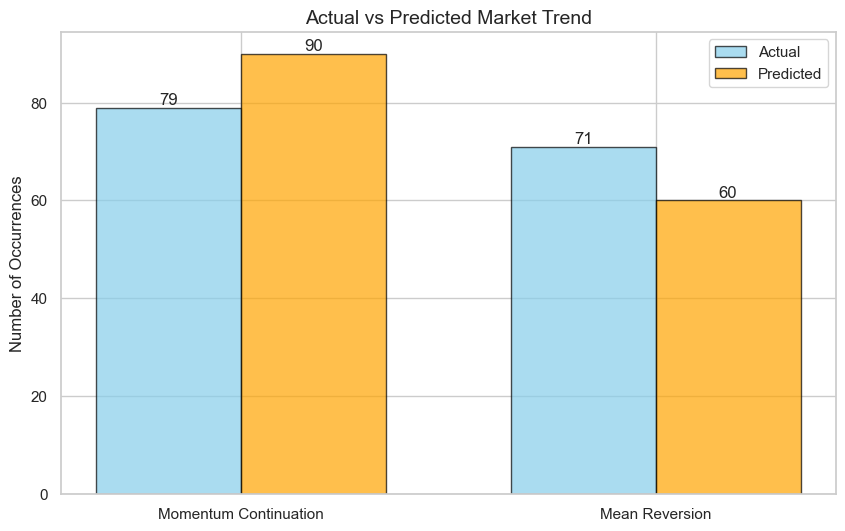

In [13]:
sns.set(style="whitegrid")

# Plot 1.1: Number of Actual MC/MR vs Predicted MC/MR
plt.figure(figsize=(10, 6))
actual_mc_mr = trade_results_df['Actual Market Trend'].value_counts()
predicted_mc_mr = trade_results_df['Predicted Market Trend'].value_counts()

width = 0.35  #
index = range(len(actual_mc_mr))

bars1 = plt.bar(index, actual_mc_mr.values, width=width, label='Actual', alpha=0.7, color='skyblue', edgecolor='black')
bars2 = plt.bar([i + width for i in index], predicted_mc_mr.values, width=width, label='Predicted', alpha=0.7, color='orange', edgecolor='black')

plt.ylabel('Number of Occurrences')
plt.title('Actual vs Predicted Market Trend', fontsize=14)
plt.xticks([i + width/2 for i in index], actual_mc_mr.index)
plt.legend()

for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()

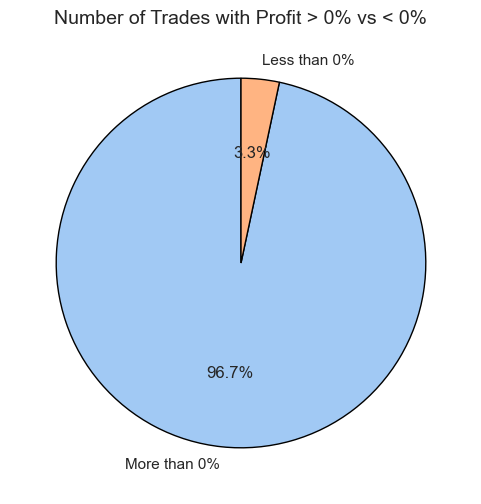

In [55]:
# Plot: Number of trades with profit more than 2% and less than 2% (Pie chart)
plt.figure(figsize=(6, 6))

# Create profit categories
trade_results_df['Profit Category'] = trade_results_df['Profit'].apply(lambda x: 'More than 0%' if x > 0 else 'Less than 0%')
profit_counts = trade_results_df['Profit Category'].value_counts()

# Create pie chart
plt.pie(profit_counts.values, labels=profit_counts.index, autopct='%1.1f%%', colors=sns.color_palette("pastel", len(profit_counts)), startangle=90, wedgeprops={'edgecolor': 'black'})

# Add title
plt.title('Number of Trades with Profit > 0% vs < 0%', fontsize=14)

# Display the pie chart
plt.show()

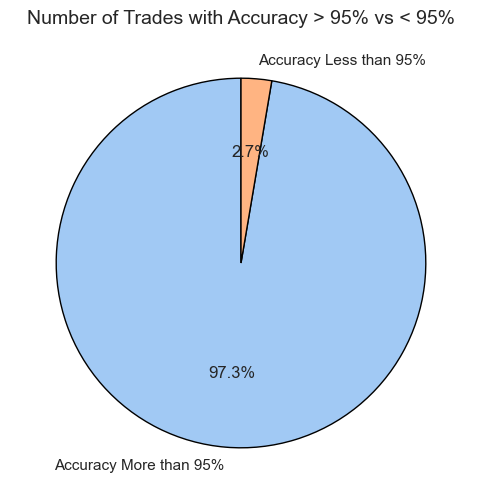

In [17]:
# Plot: Number of trades with accuracy more than 95% and less than 95% (Pie chart)
plt.figure(figsize=(6, 6))

# Create accuracy categories
trade_results_df['Accuracy Category'] = trade_results_df['model_accuracy'].apply(lambda x: 'Accuracy More than 95%' if x > 95 else 'Accuracy Less than 95%')
accuracy_counts = trade_results_df['Accuracy Category'].value_counts()

# Create pie chart
plt.pie(accuracy_counts.values, labels=accuracy_counts.index, autopct='%1.1f%%', 
        colors=sns.color_palette("pastel", len(accuracy_counts)), startangle=90, 
        wedgeprops={'edgecolor': 'black'})

# Add title
plt.title('Number of Trades with Accuracy > 95% vs < 95%', fontsize=14)

# Display the pie chart
plt.show()

In [29]:
# Group by 'Pair' and find the min and max profit for each pair
profit_stats = sorted_trade_results_df.groupby('Pair')['Profit'].agg(['min', 'max']).reset_index()

# Display the results
print(profit_stats)

     Pair       min       max
0  USDAUD  0.002169  4.390756
1  USDCAD  0.000000  2.176630
2  USDCHF  0.000000  3.191827
3  USDEUR  0.000000  3.199482
4  USDGBP  0.000734  7.328917
